In [656]:
# Let's import necessary lybraries
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # For creating multiclass data
from sklearn.model_selection import train_test_split  # For spliting dataset

In [657]:
# Check torch version
torch.__version__

'1.13.0+cu116'

Specifically, let's do the following:

1. Create some multi-class data with make_blobs().
2. Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
3. Split the data into training and test sets using train_test_split().
4. Visualize the data.

In [658]:
# Set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [659]:
# Create data
X_blob, y_blob = make_blobs (n_samples = 2000,
                             n_features = NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std = 3,
                             random_state = RANDOM_SEED)

In [660]:
# Let's check the sahpe of features and labels
X_blob.shape, y_blob.shape

((2000, 2), (2000,))

In [661]:
# Let's turn our data to tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Let's check shape again
X_blob.shape, y_blob.shape

(torch.Size([2000, 2]), torch.Size([2000]))

In [662]:
# Split data for train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state=RANDOM_SEED)

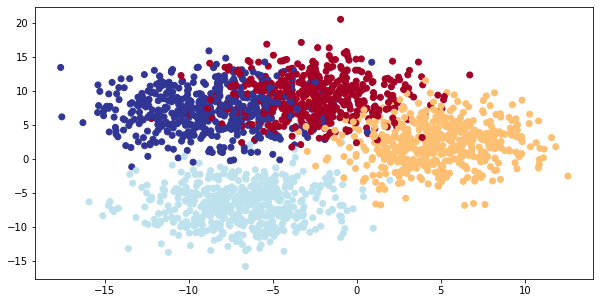

In [663]:
# Plot data
plt.figure(figsize = (10, 5))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [664]:
# Let's chcek our class label
torch.unique(y_blob_train), torch.unique(y_blob_test)

(tensor([0, 1, 2, 3]), tensor([0, 1, 2, 3]))

## Multiclass classification model

In [665]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [666]:
# Model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        # nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return(self.linear_layer_stack(x))


In [667]:
# Let's create a model instance and send to the target device

model_1 = BlobModel(input_features=2,
                   output_features = 4,
                   hidden_units = 8).to(device)

model_1

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [668]:
# Let's chcek model parameters
model_1.state_dict()

OrderedDict([('linear_layer_stack.0.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.2767, -0.2512,  0

In [669]:
# Set loss and optimizer
# Loss
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) # lr is a hyperparameter we can change

In [670]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Getting prediction probabilities before training

> **Logits (Raw output of the model) -> Pred Probs -> Pred Labels**

In [671]:
# Logits from the model prediction raw outputs
model_1.eval()
with torch.inference_mode():

  logit = model_1(X_blob_test.to(device))
logit[:5]

tensor([[-0.3713, -1.5103, -1.3227, -0.4085],
        [ 0.2365, -0.2581,  0.1439,  0.0147],
        [-0.1835, -1.1353, -0.7910, -0.1888],
        [ 0.0957, -0.5252, -0.1308,  0.0082],
        [-0.0438, -0.8268, -0.4682, -0.0978]])

In [672]:
# Use sigmoid on model to conver logits to prediction probabilities
pred_probs = torch.softmax(logit, dim=1)
pred_probs[:5]

tensor([[0.3746, 0.1199, 0.1447, 0.3609],
        [0.3010, 0.1835, 0.2744, 0.2411],
        [0.3418, 0.1320, 0.1862, 0.3400],
        [0.3076, 0.1653, 0.2453, 0.2818],
        [0.3270, 0.1494, 0.2139, 0.3098]])

In [673]:
pred_probs.shape

torch.Size([400, 4])

In [674]:
# Let's check out logits and pred_probs
print(f"Logits: {logit[:5]}")
print(f"\nPrediction Probabilities: {pred_probs[:5]}")

Logits: tensor([[-0.3713, -1.5103, -1.3227, -0.4085],
        [ 0.2365, -0.2581,  0.1439,  0.0147],
        [-0.1835, -1.1353, -0.7910, -0.1888],
        [ 0.0957, -0.5252, -0.1308,  0.0082],
        [-0.0438, -0.8268, -0.4682, -0.0978]])

Prediction Probabilities: tensor([[0.3746, 0.1199, 0.1447, 0.3609],
        [0.3010, 0.1835, 0.2744, 0.2411],
        [0.3418, 0.1320, 0.1862, 0.3400],
        [0.3076, 0.1653, 0.2453, 0.2818],
        [0.3270, 0.1494, 0.2139, 0.3098]])


In [675]:
# Sum the first sample output of the softmax activation function 
print(f"Summation of first sample output: {torch.sum(pred_probs[0])}")
print(f"Maximum of first sample output: {torch.max(pred_probs[0])}")
print(f"Prediction index class of first sample output: {torch.argmax(pred_probs[0])}")

Summation of first sample output: 1.0
Maximum of first sample output: 0.3745630085468292
Prediction index class of first sample output: 0


In [676]:
# Comvert prediction probabilities to prediction's labes
preds = torch.argmax(pred_probs, dim=1)
preds[:5]

tensor([0, 0, 0, 0, 0])

In [677]:
# Ground truth
y_blob_test[:5]

tensor([0, 2, 3, 2, 3])

In [678]:
# Check equality
torch.eq(preds[:5], y_blob_test[:5])

tensor([ True, False, False, False, False])

### Create training and testing loop

In [679]:
# Manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epoch
epochs = 1000

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop trouht the data

for epoch in range(epochs):

  #### Training loop
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  train_loss = loss_fn(y_logits, y_blob_train)
  train_acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  train_loss.backward()

  # 5. Optimizer step()
  optimizer.step()

  #### Test Loop
  model_1.eval()

  with torch.inference_mode():

    # 1. Forward pass
    test_logit = model_1(X_blob_test)
    test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

    # 2. Loss calculation
    test_loss = loss_fn(test_logit, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                    y_pred = test_pred)
    
  # Print out what's happen
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 1.1756 | Train Accuracy: 41.81% | Test Loss: 1.1221 | Test Accuracy: 46.00%
Epoch: 10 | Train Loss: 0.7738 | Train Accuracy: 83.75% | Test Loss: 0.7999 | Test Accuracy: 84.25%
Epoch: 20 | Train Loss: 0.5981 | Train Accuracy: 87.88% | Test Loss: 0.6308 | Test Accuracy: 86.00%
Epoch: 30 | Train Loss: 0.4620 | Train Accuracy: 89.19% | Test Loss: 0.4839 | Test Accuracy: 88.00%
Epoch: 40 | Train Loss: 0.3449 | Train Accuracy: 89.25% | Test Loss: 0.3613 | Test Accuracy: 88.00%
Epoch: 50 | Train Loss: 0.3047 | Train Accuracy: 89.31% | Test Loss: 0.3228 | Test Accuracy: 88.00%
Epoch: 60 | Train Loss: 0.2908 | Train Accuracy: 89.44% | Test Loss: 0.3097 | Test Accuracy: 88.25%
Epoch: 70 | Train Loss: 0.2839 | Train Accuracy: 89.44% | Test Loss: 0.3025 | Test Accuracy: 88.25%
Epoch: 80 | Train Loss: 0.2796 | Train Accuracy: 89.62% | Test Loss: 0.2977 | Test Accuracy: 88.25%
Epoch: 90 | Train Loss: 0.2792 | Train Accuracy: 89.38% | Test Loss: 0.3012 | Test Accuracy: 88.25%
E

In [680]:
# Plot predctions function 
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [681]:
# Let's make prediction after training
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

In [682]:
# Let's print first 10 predictions from logits
y_logits[:10]

tensor([[  2.3921,  -3.1591, -10.4116,  -0.5871],
        [ -7.7277,  -4.9345,   5.5725,  -3.2666],
        [  0.1395,  -7.0922,  -7.2621,   3.2908],
        [ -7.5381,  -6.1259,   4.0690,  -1.4091],
        [ -0.3124,  -4.7620,  -4.3937,   2.4389],
        [  0.3265,  -5.6466,  -6.0277,   2.4011],
        [ -1.4057,   1.9022,   0.9049,  -2.0278],
        [ -0.8373,   3.0508,  -0.8537,  -2.6076],
        [  0.1945,  -6.3528,  -6.5832,   2.8671],
        [  1.0856,  -4.0602,  -6.0521,   0.9786]])

In [683]:
# Let's print first 10 predictions from predction probabilities
y_preds[:10]

tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0])

In [684]:
# Print ground truth values and compare
print(f"Ground Truth Values: {y_blob_test[:10]}")

# Compare
print(f"Comparison: {torch.eq(y_preds[:10], y_blob_test[:10])}")

Ground Truth Values: tensor([0, 2, 3, 2, 3, 3, 1, 1, 3, 0])
Comparison: tensor([True, True, True, True, True, True, True, True, True, True])


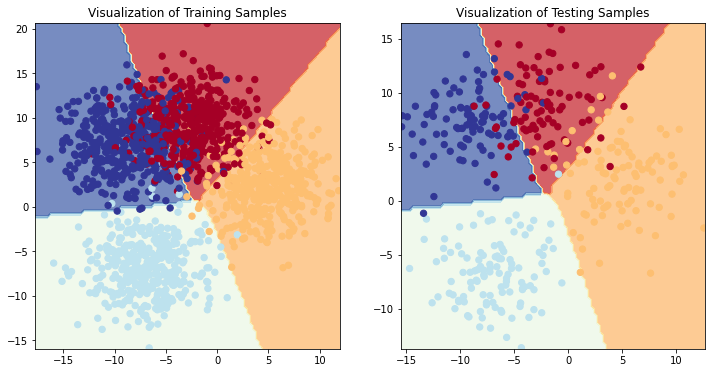

In [685]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Visualization of Training Samples")
plot_decision_boundary(model_1, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Visualization of Testing Samples")
plot_decision_boundary(model_1, X_blob_test, y_blob_test)